### Decisions to make
### 1. 
1. 
```
data['season_end_top_10'] = data.groupby('season')['driver_points'].transform(lambda x: x >= x.nlargest(10).min())
y = data['season_end_top_10']
```
2. 
```
data['top_10_finish'] = np.where(data['podium'] <= 10, 1, 0)
y = data['top_10_finish']
```
3. 
```
y = data['podium'] 
```
Key Differenced: 
* The first method determines if a driver finished in the top 10 in terms of points at the end of a season.
* The first method uses group-wise operation (grouping by 'season'), while the second line applies a condition to each row independently.
* The second method simply marks whether a driver finished in the top 10 in a particular event (not considering the entire season).
* The third method is just something I tried, seem pretty bad.

From the looks of it, method 1 makes best predictions. Gets all first 3 places correct with RL and NBC.

### 2. 
What kind of accuracy do we want to calculate?
1. In top 10 (True/False)
2. By standing

Currently, I am computing the accuracy with top 10 seasonal standing, i.e., final standing, by `driver_name`.
```
accuracy = calc_acc(y_test, y_pred)
```
where `y_pred` is computed by:
1. predicting the ranking of each round of a season
2. assign points to the top 10
3. sum all points by driver
4. return driver_name of the top 10 drivers with most point in sorted order

and `y_test` is computed in similar fasion but using real data.

I personally think this accuracy isn't that meaningful because we are only comparing a single season. 

If we were to predict the seasonal top 10 for every season, this method of computing accuracy would make more sense.

The NDCG score is quite interesting because it evaluates the ranking even if they do not match exactly (unlike accuracy). 

### 3. 
What feature do we want to include for training?
1. With weather
2. Without weather
3. All features

I've tried the feature set that Nishtha/Daniel provided (with weather) and the feature set that Joan/Mayesha has provided (without weather) and it seems like the model performed better without weather.

During training, I ran into warnings `have not converged after reaching max_iter` for both LR and NN. Maybe less features is better. 

# Predictions of Standing for Each Round with Chosen Features

In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# X = data[features]
# # y = data['podium']
# # y = data['top_10_finish']
# y = data['season_end_top_10']
# X_train = X[data['season'] < 2022]
# y_train = y[data['season'] < 2022]
# X_test = X[data['season'] == 2022]

PODIUM = 1
TOP_10 = 2

def get_data_for_year(file, year, features, years_back=None, acc_type=PODIUM):
    """
    file: file path to csv file
    year: year to get data for
    features: list of features to use
    target: target variable (single string)
    """
    data = pd.read_csv(file)
    # data['top_10_finish'] = np.where(data['podium'] <= 10, 1, 0)
    data['season_end_top_10'] = data.groupby('season')['driver_points'].transform(lambda x: x >= x.nlargest(10).min())

    from_year = 2015
    
    if years_back:
        from_year = year - years_back
    
    to_year = year - 1
    condition = (data['season'] >= from_year) & (data['season'] <= to_year)
    
    X_train = data[condition][features]
    y_train = data[condition]['season_end_top_10']
    X_test = data[data['season'] == year][features]
    # display(X_train)
    if acc_type == PODIUM:
        data_w_points = pd.read_csv('./data/final_df.csv')
        y_test = data_w_points[data_w_points['season'] == year]
        y_test = y_test.groupby('driver_name')['points'].sum().reset_index()
        y_test = y_test.sort_values('points', ascending=False)
        y_test = y_test.iloc[0:10].reset_index(drop=True)
    elif acc_type == TOP_10:
        y_test = data[data['season'] == year]['season_end_top_10']

    return X_train, y_train, X_test, y_test

Accuracy for 2022 season: 0.5
Logistic Regression


/Users/mauricechiu/opt/anaconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,actual_season_standing,predicted_season_standing,predicted_points
12,max verstappen,max verstappen,463
2,charles leclerc,charles leclerc,374
16,sergio perez,sergio perez,344
1,george russell,carlos sainz,254
6,lewis hamilton,george russell,233
11,carlos sainz,lewis hamilton,174
10,lando norris,lando norris,118
4,esteban ocon,esteban ocon,73
17,fernando alonso,valtteri bottas,53
8,valtteri bottas,kevin magnussen,45


Accuracy for 2023 season: 0.1
Neural Network


,actual_season_standing,predicted_season_standing,predicted_points
14,max verstappen,max verstappen,461
11,charles leclerc,lewis hamilton,226
1,sergio perez,carlos sainz,217
19,george russell,sergio perez,188
5,lewis hamilton,fernando alonso,170
10,carlos sainz,lando norris,152
2,lando norris,charles leclerc,149
6,esteban ocon,george russell,135
17,fernando alonso,oscar piastri,83
4,valtteri bottas,esteban ocon,78


Accuracy for 2022 season: 0.7
Naive Bayes Classifier


,actual_season_standing,predicted_season_standing,predicted_points
10,max verstappen,max verstappen,471
1,charles leclerc,charles leclerc,393
12,sergio perez,sergio perez,339
0,george russell,carlos sainz,291
5,lewis hamilton,george russell,235
9,carlos sainz,lewis hamilton,189
8,lando norris,lando norris,93
3,esteban ocon,esteban ocon,88
4,fernando alonso,fernando alonso,44
13,valtteri bottas,valtteri bottas,36


,model,accuracy,pred_champion,pred_champion_points,mean_ndcg
0,LR,0.5,max verstappen,463,0.832180
1,NN,0.1,max verstappen,461,0.846201
2,NBC,0.7,max verstappen,471,0.844071


,model,mean_ndcg
0,LR,0.832180
1,NN,0.846201
2,NBC,0.844071


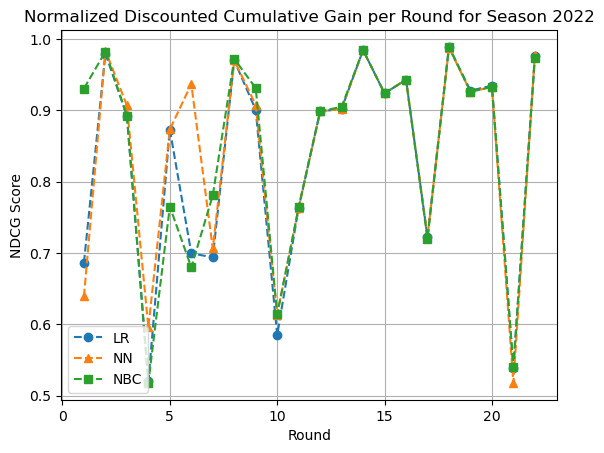

In [91]:
def calculate_dcg(relevances, p):
    dcg = 0
    for i in range(p):
        dcg += (2 ** relevances[i] - 1) / np.log2(i + 2)
    return dcg

def calculate_ndcg(relevances, p):
    dcg = calculate_dcg(relevances, p)
    idcg = calculate_dcg(sorted(relevances, reverse=True), p)
    return dcg / idcg if idcg != 0 else 0

def map_true_relevances_to_predicted_order(true_relevances, predicted_relevances):
    # print(f"true_relevances: {true_relevances}")
    # print(f"predicted_relevances: {predicted_relevances}")
    sorted_indices = np.argsort(predicted_relevances)[::-1]
    # print(f"sorted_indices: {sorted_indices}")
    mapped_true_relevances = np.array(true_relevances)[sorted_indices]
    # print(f"mapped_true_relevances: {mapped_true_relevances}")
    return mapped_true_relevances

#Finding season winners based on points
points_system = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}
# Function to assign points based on predicted position
def assign_points(df):
    df['predicted_points'] = df.groupby('round').cumcount() + 1
    df['predicted_points'] = df['predicted_points'].map(points_system).fillna(0)
    return df

def assign_relevance(values):
    # Sorting the list in ascending order
    sorted_values = sorted(values)
    # Assigning points: highest (10) to lowest (1)
    points = {value: 10 - i for i, value in enumerate(sorted_values)}
    rel = [points[val] for val in values]
    return rel

LR = 1
NN = 2
NBC = 3

def fit_n_pred(model_id, year, X_train, y_train, X_test, y_test, output=False, acc_type=PODIUM):
    data_pre_proc = pd.read_csv('./data/preprocessed_df.csv')
    if model_id == 1:
        model = LogisticRegression(penalty='l1', solver='saga', C=10.0, max_iter=1500)
    elif model_id == 2:
        model = MLPClassifier(hidden_layer_sizes=(80,20,40,5), activation='relu', solver='adam', alpha=1.2742749857031321, batch_size= 100, random_state=0, max_iter=2000)
    elif model_id == 3:
        model = GaussianNB(var_smoothing=2.848035868435799e-05)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model.fit(X_train_scaled, y_train)
    data_year = data_pre_proc[data_pre_proc['season'] == year].copy()
    data_year.loc[:, 'pred_probability'] = model.predict_proba(X_test_scaled)[:, 1]
    top_10_predictions = data_year.groupby('round').apply(lambda x: x.nlargest(10, 'pred_probability')).reset_index(drop=True)
    if acc_type == TOP_10: 
        y_pred = top_10_predictions.head(10)
    unique_rounds = data_year['round'].unique()
    mapped_revs = []
    ideal_revs = []
    for r in unique_rounds:
        round_predictions = top_10_predictions[top_10_predictions['round'] == r]
        round_predictions = round_predictions[['season', 'round', 'driver_name', 'pred_probability', 'podium']]
        round_predictions = round_predictions.reset_index(drop=True)
        round_predictions['pred_podium'] = round_predictions.index + 1
        
        # print(f"Round {r} predictions:")
        # display(round_predictions[['driver_name', 'podium', 'pred_podium']])
        
        podium_vals = round_predictions['podium'].tolist()
        podium_vals = [int(val) for val in podium_vals]
        true_relevances = assign_relevance(podium_vals)
        predicted_relevances = assign_relevance(round_predictions['pred_podium'].tolist())
        
        # Map true relevances to the order of predicted relevances
        mapped_true_relevances = map_true_relevances_to_predicted_order(true_relevances, predicted_relevances)
        # Calculate NDCG for the mapped true relevances
        ndcg_score_mapped = calculate_ndcg(mapped_true_relevances, len(mapped_true_relevances))
        # Calculate ideal NDCG for true relevances
        ideal_ndcg_score = calculate_ndcg(sorted(true_relevances, reverse=True), len(true_relevances))
        mapped_revs.append(ndcg_score_mapped)
        ideal_revs.append(ideal_ndcg_score)

    top_10_predictions = assign_points(top_10_predictions)
    # Summing up points for each driver
    season_points = top_10_predictions.groupby('driver_name')['predicted_points'].sum().reset_index()
    # Sorting drivers based on total points
    season_points = season_points.sort_values('predicted_points', ascending=False)

    if acc_type == PODIUM:
        y_test = y_test['driver_name'].tolist()
        y_pred = season_points['driver_name'].head(10).tolist()
    elif acc_type == TOP_10:
        y_test = y_test.tolist()

    accuracy = accuracy_score(y_test, y_pred)
    
    if output: print(f"Accuracy for {year} season: {accuracy}")
    if output:
        if model_id == 1:
            print("Logistic Regression")
        elif model_id == 2:
            print("Neural Network")
        elif model_id == 3:
            print("Naive Bayes Classifier")
    comp_df = pd.DataFrame({'actual_season_standing': y_test, 'predicted_season_standing': y_pred, 'predicted_points': season_points['predicted_points'].head(10)})
    if output: display(comp_df)

    pred_champ = season_points.iloc[0]['driver_name']
    pred_champ_points = season_points.iloc[0]['predicted_points']

    return (y_pred, accuracy, mapped_revs, ideal_revs, pred_champ, pred_champ_points)

# ====================
file = './data/preprocessed_df.csv'

# features = [
#     'season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins', 
#     'constructor_points', 'constructor_standings_pos', 'constructor_wins',
#     'fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3',
#     'weather_cloudy', 'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet'
# ]
features = ['season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins',
            'constructor_points', 'constructor_standings_pos', 'constructor_wins']
additional_features = ['fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3']
features = features + additional_features

X_train, y_train, X_test, y_test = get_data_for_year(file, 2022, features)

(lr_pred, lr_acc, lr_mapped_revs, lr_ideal_revs, lr_champ, lr_champ_pts) = fit_n_pred(LR, 2022, X_train, y_train, X_test, y_test, output=True)
(nn_pred, nn_acc, nn_mapped_revs, nn_ideal_revs, nn_champ, nn_champ_pts) = fit_n_pred(NN, year, X_train, y_train, X_test, y_test, output=True)
(nbc_pred, nbc_acc, nbc_mapped_revs, nbc_ideal_revs, nbc_champ, nbc_champ_pts) = fit_n_pred(NBC, 2022, X_train, y_train, X_test, y_test, output=True)

# print("Accuracy for 2022 season:", nn_acc)
# print(nn_pred)
# print(f"Champion of 2022 season: {champ} with {champ_pts} points")
lr_mean_mapped_revs = np.mean(lr_mapped_revs)
nn_mean_mapped_revs = np.mean(nn_mapped_revs)
nbc_mean_mapped_revs = np.mean(nbc_mapped_revs)

results = {"model": ["LR", "NN", "NBC"], "accuracy": [lr_acc, nn_acc, nbc_acc], "pred_champion": [lr_champ, nn_champ, nbc_champ], "pred_champion_points": [lr_champ_pts, nn_champ_pts, nbc_champ_pts], "mean_ndcg": [lr_mean_mapped_revs, nn_mean_mapped_revs, nbc_mean_mapped_revs]}
results_df = pd.DataFrame(results)
display(results_df)
display(results_df[['model', 'mean_ndcg']])
# display(y_test)

plt.figure()
plt.plot(range(1, len(lr_mapped_revs)+1), lr_mapped_revs, linestyle='--', marker='o', label='LR')
plt.plot(range(1, len(nn_mapped_revs)+1), nn_mapped_revs, linestyle='--',marker='^', label='NN')
plt.plot(range(1, len(nbc_mapped_revs)+1), nbc_mapped_revs, linestyle='--',marker='s', label='NBC')
plt.xlabel('Round')
plt.ylabel('NDCG Score')
plt.legend()
plt.title('Normalized Discounted Cumulative Gain per Round for Season 2022')
plt.grid(True)
plt.show()

# Predictions for seasn 2021 - 2023
Predicting each season using data from 4 seasons back. 

With these models we predicted the top 10 positions during each race of the whole season and the top podium finishers for each season.

/Users/mauricechiu/opt/anaconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,actual_standing_2019,LR_2019,NN_2019,NBC_2019
0,lewis hamilton,lewis hamilton,lewis hamilton,lewis hamilton
1,valtteri bottas,robert kubica,valtteri bottas,valtteri bottas
2,max verstappen,george russell,max verstappen,sebastian vettel
3,charles leclerc,valtteri bottas,charles leclerc,charles leclerc
4,sebastian vettel,max verstappen,sebastian vettel,max verstappen
5,carlos sainz,antonio giovinazzi,pierre gasly,pierre gasly
6,pierre gasly,charles leclerc,carlos sainz,carlos sainz
7,alex albon,sebastian vettel,alex albon,alex albon
8,daniel ricciardo,romain grosjean,lando norris,lando norris
9,sergio perez,alex albon,kimi raikkonen,kimi raikkonen


\begin{table}[ht]
\centering
\begin{tabular}{llll}
\toprule
actual_standing_2019 & LR_2019 & NN_2019 & NBC_2019 \\
\midrule
lewis hamilton & lewis hamilton & lewis hamilton & lewis hamilton \\
valtteri bottas & robert kubica & valtteri bottas & valtteri bottas \\
max verstappen & george russell & max verstappen & sebastian vettel \\
charles leclerc & valtteri bottas & charles leclerc & charles leclerc \\
sebastian vettel & max verstappen & sebastian vettel & max verstappen \\
carlos sainz & antonio giovinazzi & pierre gasly & pierre gasly \\
pierre gasly & charles leclerc & carlos sainz & carlos sainz \\
alex albon & sebastian vettel & alex albon & alex albon \\
daniel ricciardo & romain grosjean & lando norris & lando norris \\
sergio perez & alex albon & kimi raikkonen & kimi raikkonen \\
\bottomrule
\end{tabular}

\caption{Predicted Podiums for 2019}
\label{tab:predicted_podiums_2019}
\end{table}


/Users/mauricechiu/opt/anaconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,actual_standing_2020,LR_2020,NN_2020,NBC_2020
0,lewis hamilton,nicholas latifi,lewis hamilton,lewis hamilton
1,valtteri bottas,george russell,valtteri bottas,valtteri bottas
2,max verstappen,romain grosjean,max verstappen,max verstappen
3,sergio perez,lewis hamilton,alex albon,alex albon
4,daniel ricciardo,kevin magnussen,lando norris,lando norris
5,alex albon,kimi raikkonen,charles leclerc,sergio perez
6,carlos sainz,valtteri bottas,pierre gasly,charles leclerc
7,charles leclerc,antonio giovinazzi,sergio perez,lance stroll
8,lando norris,daniil kvyat,daniel ricciardo,daniel ricciardo
9,pierre gasly,max verstappen,carlos sainz,carlos sainz


\begin{table}[ht]
\centering
\begin{tabular}{llll}
\toprule
actual_standing_2020 & LR_2020 & NN_2020 & NBC_2020 \\
\midrule
lewis hamilton & nicholas latifi & lewis hamilton & lewis hamilton \\
valtteri bottas & george russell & valtteri bottas & valtteri bottas \\
max verstappen & romain grosjean & max verstappen & max verstappen \\
sergio perez & lewis hamilton & alex albon & alex albon \\
daniel ricciardo & kevin magnussen & lando norris & lando norris \\
alex albon & kimi raikkonen & charles leclerc & sergio perez \\
carlos sainz & valtteri bottas & pierre gasly & charles leclerc \\
charles leclerc & antonio giovinazzi & sergio perez & lance stroll \\
lando norris & daniil kvyat & daniel ricciardo & daniel ricciardo \\
pierre gasly & max verstappen & carlos sainz & carlos sainz \\
\bottomrule
\end{tabular}

\caption{Predicted Podiums for 2020}
\label{tab:predicted_podiums_2020}
\end{table}


/Users/mauricechiu/opt/anaconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,actual_standing_2021,LR_2021,NN_2021,NBC_2021
0,lewis hamilton,max verstappen,max verstappen,max verstappen
1,max verstappen,sergio perez,lewis hamilton,lewis hamilton
2,valtteri bottas,valtteri bottas,sergio perez,valtteri bottas
3,sergio perez,lewis hamilton,valtteri bottas,sergio perez
4,carlos sainz,lando norris,lando norris,lando norris
5,lando norris,charles leclerc,daniel ricciardo,charles leclerc
6,charles leclerc,daniel ricciardo,charles leclerc,carlos sainz
7,daniel ricciardo,pierre gasly,esteban ocon,daniel ricciardo
8,pierre gasly,carlos sainz,carlos sainz,pierre gasly
9,fernando alonso,fernando alonso,pierre gasly,fernando alonso


\begin{table}[ht]
\centering
\begin{tabular}{llll}
\toprule
actual_standing_2021 & LR_2021 & NN_2021 & NBC_2021 \\
\midrule
lewis hamilton & max verstappen & max verstappen & max verstappen \\
max verstappen & sergio perez & lewis hamilton & lewis hamilton \\
valtteri bottas & valtteri bottas & sergio perez & valtteri bottas \\
sergio perez & lewis hamilton & valtteri bottas & sergio perez \\
carlos sainz & lando norris & lando norris & lando norris \\
lando norris & charles leclerc & daniel ricciardo & charles leclerc \\
charles leclerc & daniel ricciardo & charles leclerc & carlos sainz \\
daniel ricciardo & pierre gasly & esteban ocon & daniel ricciardo \\
pierre gasly & carlos sainz & carlos sainz & pierre gasly \\
fernando alonso & fernando alonso & pierre gasly & fernando alonso \\
\bottomrule
\end{tabular}

\caption{Predicted Podiums for 2021}
\label{tab:predicted_podiums_2021}
\end{table}


/Users/mauricechiu/opt/anaconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,actual_standing_2022,LR_2022,NN_2022,NBC_2022
0,max verstappen,max verstappen,max verstappen,max verstappen
1,charles leclerc,charles leclerc,charles leclerc,charles leclerc
2,sergio perez,sergio perez,sergio perez,sergio perez
3,george russell,carlos sainz,carlos sainz,carlos sainz
4,lewis hamilton,george russell,george russell,george russell
5,carlos sainz,lewis hamilton,lewis hamilton,lewis hamilton
6,lando norris,lando norris,lando norris,lando norris
7,esteban ocon,esteban ocon,esteban ocon,esteban ocon
8,fernando alonso,valtteri bottas,valtteri bottas,fernando alonso
9,valtteri bottas,kevin magnussen,fernando alonso,valtteri bottas


\begin{table}[ht]
\centering
\begin{tabular}{llll}
\toprule
actual_standing_2022 & LR_2022 & NN_2022 & NBC_2022 \\
\midrule
max verstappen & max verstappen & max verstappen & max verstappen \\
charles leclerc & charles leclerc & charles leclerc & charles leclerc \\
sergio perez & sergio perez & sergio perez & sergio perez \\
george russell & carlos sainz & carlos sainz & carlos sainz \\
lewis hamilton & george russell & george russell & george russell \\
carlos sainz & lewis hamilton & lewis hamilton & lewis hamilton \\
lando norris & lando norris & lando norris & lando norris \\
esteban ocon & esteban ocon & esteban ocon & esteban ocon \\
fernando alonso & valtteri bottas & valtteri bottas & fernando alonso \\
valtteri bottas & kevin magnussen & fernando alonso & valtteri bottas \\
\bottomrule
\end{tabular}

\caption{Predicted Podiums for 2022}
\label{tab:predicted_podiums_2022}
\end{table}


/Users/mauricechiu/opt/anaconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,actual_standing_2023,LR_2023,NN_2023,NBC_2023
0,max verstappen,max verstappen,max verstappen,max verstappen
1,sergio perez,sergio perez,sergio perez,sergio perez
2,lewis hamilton,fernando alonso,fernando alonso,lewis hamilton
3,fernando alonso,lewis hamilton,lewis hamilton,fernando alonso
4,charles leclerc,carlos sainz,carlos sainz,carlos sainz
5,lando norris,george russell,charles leclerc,george russell
6,carlos sainz,charles leclerc,george russell,charles leclerc
7,george russell,lando norris,lance stroll,lance stroll
8,oscar piastri,lance stroll,lando norris,lando norris
9,lance stroll,pierre gasly,oscar piastri,oscar piastri


\begin{table}[ht]
\centering
\begin{tabular}{llll}
\toprule
actual_standing_2023 & LR_2023 & NN_2023 & NBC_2023 \\
\midrule
max verstappen & max verstappen & max verstappen & max verstappen \\
sergio perez & sergio perez & sergio perez & sergio perez \\
lewis hamilton & fernando alonso & fernando alonso & lewis hamilton \\
fernando alonso & lewis hamilton & lewis hamilton & fernando alonso \\
charles leclerc & carlos sainz & carlos sainz & carlos sainz \\
lando norris & george russell & charles leclerc & george russell \\
carlos sainz & charles leclerc & george russell & charles leclerc \\
george russell & lando norris & lance stroll & lance stroll \\
oscar piastri & lance stroll & lando norris & lando norris \\
lance stroll & pierre gasly & oscar piastri & oscar piastri \\
\bottomrule
\end{tabular}

\caption{Predicted Podiums for 2023}
\label{tab:predicted_podiums_2023}
\end{table}


,actual_standing_2019,LR_2019,NN_2019,NBC_2019,actual_standing_2020,LR_2020,NN_2020,NBC_2020,actual_standing_2021,LR_2021,NN_2021,NBC_2021,actual_standing_2022,LR_2022,NN_2022,NBC_2022,actual_standing_2023,LR_2023,NN_2023,NBC_2023
0,lewis hamilton,lewis hamilton,lewis hamilton,lewis hamilton,lewis hamilton,nicholas latifi,lewis hamilton,lewis hamilton,lewis hamilton,max verstappen,max verstappen,max verstappen,max verstappen,max verstappen,max verstappen,max verstappen,max verstappen,max verstappen,max verstappen,max verstappen
1,valtteri bottas,robert kubica,valtteri bottas,valtteri bottas,valtteri bottas,george russell,valtteri bottas,valtteri bottas,max verstappen,sergio perez,lewis hamilton,lewis hamilton,charles leclerc,charles leclerc,charles leclerc,charles leclerc,sergio perez,sergio perez,sergio perez,sergio perez
2,max verstappen,george russell,max verstappen,sebastian vettel,max verstappen,romain grosjean,max verstappen,max verstappen,valtteri bottas,valtteri bottas,sergio perez,valtteri bottas,sergio perez,sergio perez,sergio perez,sergio perez,lewis hamilton,fernando alonso,fernando alonso,lewis hamilton
3,charles leclerc,valtteri bottas,charles leclerc,charles leclerc,sergio perez,lewis hamilton,alex albon,alex albon,sergio perez,lewis hamilton,valtteri bottas,sergio perez,george russell,carlos sainz,carlos sainz,carlos sainz,fernando alonso,lewis hamilton,lewis hamilton,fernando alonso
4,sebastian vettel,max verstappen,sebastian vettel,max verstappen,daniel ricciardo,kevin magnussen,lando norris,lando norris,carlos sainz,lando norris,lando norris,lando norris,lewis hamilton,george russell,george russell,george russell,charles leclerc,carlos sainz,carlos sainz,carlos sainz
5,carlos sainz,antonio giovinazzi,pierre gasly,pierre gasly,alex albon,kimi raikkonen,charles leclerc,sergio perez,lando norris,charles leclerc,daniel ricciardo,charles leclerc,carlos sainz,lewis hamilton,lewis hamilton,lewis hamilton,lando norris,george russell,charles leclerc,george russell
6,pierre gasly,charles leclerc,carlos sainz,carlos sainz,carlos sainz,valtteri bottas,pierre gasly,charles leclerc,charles leclerc,daniel ricciardo,charles leclerc,carlos sainz,lando norris,lando norris,lando norris,lando norris,carlos sainz,charles leclerc,george russell,charles leclerc
7,alex albon,sebastian vettel,alex albon,alex albon,charles leclerc,antonio giovinazzi,sergio perez,lance stroll,daniel ricciardo,pierre gasly,esteban ocon,daniel ricciardo,esteban ocon,esteban ocon,esteban ocon,esteban ocon,george russell,lando norris,lance stroll,lance stroll
8,daniel ricciardo,romain grosjean,lando norris,lando norris,lando norris,daniil kvyat,daniel ricciardo,daniel ricciardo,pierre gasly,carlos sainz,carlos sainz,pierre gasly,fernando alonso,valtteri bottas,valtteri bottas,fernando alonso,oscar piastri,lance stroll,lando norris,lando norris
9,sergio perez,alex albon,kimi raikkonen,kimi raikkonen,pierre gasly,max verstappen,carlos sainz,carlos sainz,fernando alonso,fernando alonso,pierre gasly,fernando alonso,valtteri bottas,kevin magnussen,fernando alonso,valtteri bottas,lance stroll,pierre gasly,oscar piastri,oscar piastri


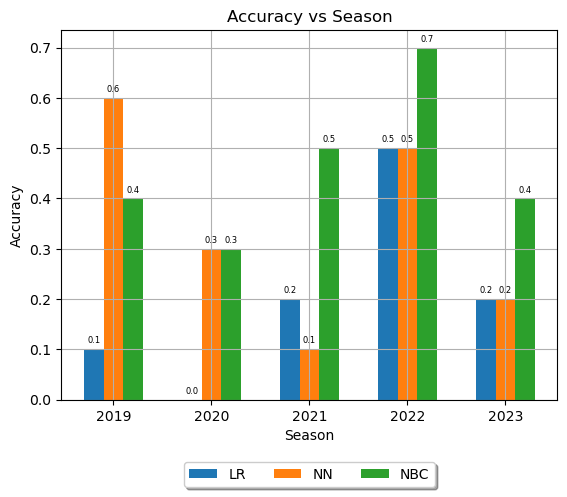

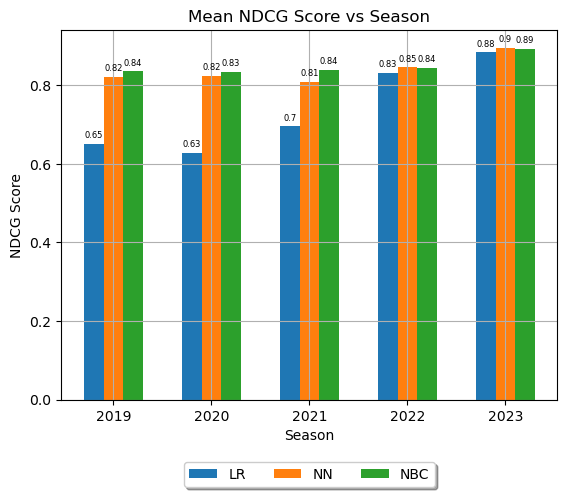

\begin{table}[ht]
\centering
\begin{tabular}{rrrrrrr}
\toprule
year & LR Acc Podium & LR NDCG & NN Acc Podium & NN NDCG & NBC Acc Podium & NBC NDCG \\
\midrule
2019 & 0.100000 & 0.651573 & 0.600000 & 0.821400 & 0.400000 & 0.835956 \\
2020 & 0.000000 & 0.627772 & 0.300000 & 0.824303 & 0.300000 & 0.834290 \\
2021 & 0.200000 & 0.695603 & 0.100000 & 0.808804 & 0.500000 & 0.839411 \\
2022 & 0.500000 & 0.832180 & 0.500000 & 0.846201 & 0.700000 & 0.844071 \\
2023 & 0.200000 & 0.884320 & 0.200000 & 0.896677 & 0.400000 & 0.892651 \\
\bottomrule
\end{tabular}

\caption{Performance Comparison}
\label{tab:perf_comp}
\end{table}


,year,LR Acc Podium,LR NDCG,NN Acc Podium,NN NDCG,NBC Acc Podium,NBC NDCG
0,2019,0.1,0.651573,0.6,0.821400,0.4,0.835956
1,2020,0.0,0.627772,0.3,0.824303,0.3,0.834290
2,2021,0.2,0.695603,0.1,0.808804,0.5,0.839411
3,2022,0.5,0.832180,0.5,0.846201,0.7,0.844071
4,2023,0.2,0.884320,0.2,0.896677,0.4,0.892651


In [92]:
def dataframe_to_latex(df, index=False, caption="Table", label="tab:my_label", position="ht"):
    """
    Convert a pandas DataFrame to a LaTeX table.

    Parameters:
    df (pd.DataFrame): The DataFrame to convert.
    index (bool): Whether to include the DataFrame's index in the table.
    caption (str): The caption for the LaTeX table.
    label (str): The label for the LaTeX table.
    position (str): The position of the table in the LaTeX document.

    Returns:
    str: A string containing the LaTeX table.
    """
    latex_str = df.to_latex(index=index)
    latex_table = f"\\begin{{table}}[{position}]\n\\centering\n{latex_str}\n\\caption{{{caption}}}\n\\label{{{label}}}\n\\end{{table}}"
    return latex_table

def create_bar_plot(data, y_label, title):
    labels = data['year']
    lr = data['LR']
    nn = data['NN']
    nbc = data['NBC']

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, lr, width, label='LR')
    rects2 = ax.bar(x, nn, width, label='NN')
    rects3 = ax.bar(x + width, nbc, width, label='NBC')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Season')
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=3)
    ax.grid(True)

    # Function to attach a text label above each bar
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=6)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.show()

file = './data/preprocessed_df.csv'

year_start = 2019
year_end = 2023
years_back = year_start - 2015

years_to_test = [y for y in range(year_start, year_end+1)]

accuracies = {
    'year': [y for y in years_to_test],
    'LR': [],
    'NN': [],
    'NBC': []
}

ndcgs = {
    'year': [y for y in years_to_test],
    'LR': [],
    'NN': [],
    'NBC': []
}

all_podiums_df = pd.DataFrame()

for year in years_to_test:

    X_train, y_train, X_test, y_test = get_data_for_year(file, year, features)

    (lr_pred, lr_acc, lr_mapped_revs, lr_ideal_revs, lr_champ, lr_champ_pts) = fit_n_pred(LR, year, X_train, y_train, X_test, y_test, output=False)
    (nn_pred, nn_acc, nn_mapped_revs, nn_ideal_revs, nn_champ, nn_champ_pts) = fit_n_pred(NN, year, X_train, y_train, X_test, y_test, output=False)
    (nbc_pred, nbc_acc, nbc_mapped_revs, nbc_ideal_revs, nbc_champ, nbc_champ_pts) = fit_n_pred(NBC, year, X_train, y_train, X_test, y_test, output=False)

    # print("Accuracy for 2022 season:", nn_acc)
    # print(nn_pred)
    # print(f"Champion of 2022 season: {champ} with {champ_pts} points")
    lr_mean_mapped_revs = np.mean(lr_mapped_revs)
    nn_mean_mapped_revs = np.mean(nn_mapped_revs)
    nbc_mean_mapped_revs = np.mean(nbc_mapped_revs)

    results = {"model": ["LR", "NN", "NBC"], "accuracy": [lr_acc, nn_acc, nbc_acc], "pred_champion": [lr_champ, nn_champ, nbc_champ], "pred_champion_points": [lr_champ_pts, nn_champ_pts, nbc_champ_pts], "mean_ndcg": [lr_mean_mapped_revs, nn_mean_mapped_revs, nbc_mean_mapped_revs]}
    results_df = pd.DataFrame(results)
    # display(results_df)
    # display(results_df[['model', 'accuracy', 'mean_ndcg']])
    # display(y_test)

    accuracies['LR'].append(lr_acc)
    accuracies['NN'].append(nn_acc)
    accuracies['NBC'].append(nbc_acc)

    ndcgs['LR'].append(lr_mean_mapped_revs)
    ndcgs['NN'].append(nn_mean_mapped_revs)
    ndcgs['NBC'].append(nbc_mean_mapped_revs)
    
    y_test = y_test.drop(columns=['points'])
    y_test = y_test.rename(columns={'driver_name': f"actual_standing_{year}"})
    podiums_df = pd.concat([y_test, pd.Series(lr_pred), pd.Series(nn_pred), pd.Series(nbc_pred)], axis=1)
    podiums_df = podiums_df.rename(columns={0: f"LR_{year}", 1: f"NN_{year}", 2: f"NBC_{year}"})
    display(podiums_df)

    latex_table = dataframe_to_latex(podiums_df, caption=f"Predicted Podiums for {year}", label=f"tab:predicted_podiums_{year}", position="ht")

    print(latex_table)

    all_podiums_df = pd.concat([all_podiums_df, podiums_df], axis=1)

display(all_podiums_df)

# Create bar plots for accuracies and NDCG scores
create_bar_plot(accuracies, 'Accuracy', 'Accuracy vs Season')
create_bar_plot(ndcgs, 'NDCG Score', 'Mean NDCG Score vs Season')

final_results_df = pd.DataFrame(accuracies)
final_results_df = final_results_df.rename(columns={'LR': 'LR Acc Podium', 'NN': 'NN Acc Podium', 'NBC': 'NBC Acc Podium'})
ndcgs_df = pd.DataFrame(ndcgs)
ndcgs_df.drop(columns=['year'], inplace=True)
final_results_df = pd.concat([final_results_df, ndcgs_df], axis=1)
final_results_df = final_results_df.rename(columns={'LR': 'LR NDCG', 'NN': 'NN NDCG', 'NBC': 'NBC NDCG'})
final_results_df = final_results_df[['year', 'LR Acc Podium', 'LR NDCG', 'NN Acc Podium', 'NN NDCG', 'NBC Acc Podium', 'NBC NDCG']]
latex_table = dataframe_to_latex(final_results_df, caption=f"Performance Comparison", label=f"tab:perf_comp", position="ht")
print(latex_table)
display(final_results_df)
final_results_df.to_csv('./final_results.csv')

# plt.figure()
# plt.plot(accuracies['year'], accuracies['LR'], linestyle='--', marker='o', label='LR')
# plt.plot(accuracies['year'], accuracies['NN'], linestyle='--',marker='^', label='NN')
# plt.plot(accuracies['year'], accuracies['NBC'], linestyle='--',marker='s', label='NBC')
# plt.xlabel('Season')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Accuracy per Season')
# plt.grid(True)
# plt.show()

# plt.figure()
# plt.plot(ndcgs['year'], ndcgs['LR'], linestyle='--', marker='o', label='LR')
# plt.plot(ndcgs['year'], ndcgs['NN'], linestyle='--',marker='^', label='NN')
# plt.plot(ndcgs['year'], ndcgs['NBC'], linestyle='--',marker='s', label='NBC')
# plt.xlabel('Season')
# plt.ylabel('NDCG Score')
# plt.legend()
# plt.title('Mean NDCG Score per Season')
# plt.grid(True)
# plt.show()

In [93]:
# file = './data/preprocessed_df.csv'

# year_start = 2019
# year_end = 2023
# years_back = year_start - 2015

# years_to_test = [y for y in range(year_start, year_end+1)]

# accuracies = {
#     'year': [y for y in years_to_test],
#     'LR': [],
#     'NN': [],
#     'NBC': []
# }

# ndcgs = {
#     'year': [y for y in years_to_test],
#     'LR': [],
#     'NN': [],
#     'NBC': []
# }

# all_podiums_df = pd.DataFrame()

# for year in years_to_test:

#     X_train, y_train, X_test, y_test = get_data_for_year(file, year, features, acc_type=TOP_10)

#     (lr_pred, lr_acc, lr_mapped_revs, lr_ideal_revs, lr_champ, lr_champ_pts) = fit_n_pred(LR, year, X_train, y_train, X_test, y_test, output=False, acc_type=TOP_10)
#     (nn_pred, nn_acc, nn_mapped_revs, nn_ideal_revs, nn_champ, nn_champ_pts) = fit_n_pred(NN, year, X_train, y_train, X_test, y_test, output=False, acc_type=TOP_10)
#     (nbc_pred, nbc_acc, nbc_mapped_revs, nbc_ideal_revs, nbc_champ, nbc_champ_pts) = fit_n_pred(NBC, year, X_train, y_train, X_test, y_test, output=False, acc_type=TOP_10)

#     # print("Accuracy for 2022 season:", nn_acc)
#     # print(nn_pred)
#     # print(f"Champion of 2022 season: {champ} with {champ_pts} points")
#     lr_mean_mapped_revs = np.mean(lr_mapped_revs)
#     nn_mean_mapped_revs = np.mean(nn_mapped_revs)
#     nbc_mean_mapped_revs = np.mean(nbc_mapped_revs)

#     results = {"model": ["LR", "NN", "NBC"], "accuracy": [lr_acc, nn_acc, nbc_acc], "pred_champion": [lr_champ, nn_champ, nbc_champ], "pred_champion_points": [lr_champ_pts, nn_champ_pts, nbc_champ_pts], "mean_ndcg": [lr_mean_mapped_revs, nn_mean_mapped_revs, nbc_mean_mapped_revs]}
#     results_df = pd.DataFrame(results)
#     # display(results_df)
#     # display(results_df[['model', 'accuracy', 'mean_ndcg']])
#     # display(y_test)

#     accuracies['LR'].append(lr_acc)
#     accuracies['NN'].append(nn_acc)
#     accuracies['NBC'].append(nbc_acc)

#     ndcgs['LR'].append(lr_mean_mapped_revs)
#     ndcgs['NN'].append(nn_mean_mapped_revs)
#     ndcgs['NBC'].append(nbc_mean_mapped_revs)
    
#     y_test = y_test.drop(columns=['points'])
#     y_test = y_test.rename(columns={'driver_name': f"actual_standing_{year}"})
#     podiums_df = pd.concat([y_test, pd.Series(lr_pred), pd.Series(nn_pred), pd.Series(nbc_pred)], axis=1)
#     podiums_df = podiums_df.rename(columns={0: f"LR_{year}", 1: f"NN_{year}", 2: f"NBC_{year}"})
#     display(podiums_df)

#     latex_table = dataframe_to_latex(podiums_df, caption=f"Predicted Podiums for {year}", label=f"tab:predicted_podiums_{year}", position="ht")

#     print(latex_table)

#     all_podiums_df = pd.concat([all_podiums_df, podiums_df], axis=1)

# display(all_podiums_df)

# # Create bar plots for accuracies and NDCG scores
# create_bar_plot(accuracies, 'Accuracy', 'Accuracy vs Season')
# create_bar_plot(ndcgs, 'NDCG Score', 'Mean NDCG Score vs Season')

# final_results_df = pd.DataFrame(accuracies)
# final_results_df = final_results_df.rename(columns={'LR': 'LR Acc', 'NN': 'NN Acc', 'NBC': 'NBC Acc'})
# ndcgs_df = pd.DataFrame(ndcgs)
# ndcgs_df.drop(columns=['year'], inplace=True)
# final_results_df = pd.concat([final_results_df, ndcgs_df], axis=1)
# final_results_df = final_results_df.rename(columns={'LR': 'LR NDCG', 'NN': 'NN NDCG', 'NBC': 'NBC NDCG'})
# final_results_df = final_results_df[['year', 'LR Acc', 'LR NDCG', 'NN Acc', 'NN NDCG', 'NBC Acc', 'NBC NDCG']]
# latex_table = dataframe_to_latex(final_results_df, caption=f"Performance Comparison", label=f"tab:perf_comp", position="ht")
# print(latex_table)
# display(final_results_df)
# final_results_df.to_csv('./final_results.csv')

# # plt.figure()
# # plt.plot(accuracies['year'], accuracies['LR'], linestyle='--', marker='o', label='LR')
# # plt.plot(accuracies['year'], accuracies['NN'], linestyle='--',marker='^', label='NN')
# # plt.plot(accuracies['year'], accuracies['NBC'], linestyle='--',marker='s', label='NBC')
# # plt.xlabel('Season')
# # plt.ylabel('Accuracy')
# # plt.legend()
# # plt.title('Accuracy per Season')
# # plt.grid(True)
# # plt.show()

# # plt.figure()
# # plt.plot(ndcgs['year'], ndcgs['LR'], linestyle='--', marker='o', label='LR')
# # plt.plot(ndcgs['year'], ndcgs['NN'], linestyle='--',marker='^', label='NN')
# # plt.plot(ndcgs['year'], ndcgs['NBC'], linestyle='--',marker='s', label='NBC')
# # plt.xlabel('Season')
# # plt.ylabel('NDCG Score')
# # plt.legend()
# # plt.title('Mean NDCG Score per Season')
# # plt.grid(True)
# # plt.show()

# Learning Curves with Chosen Features

/Users/mauricechiu/opt/anaconda3/envs/573/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


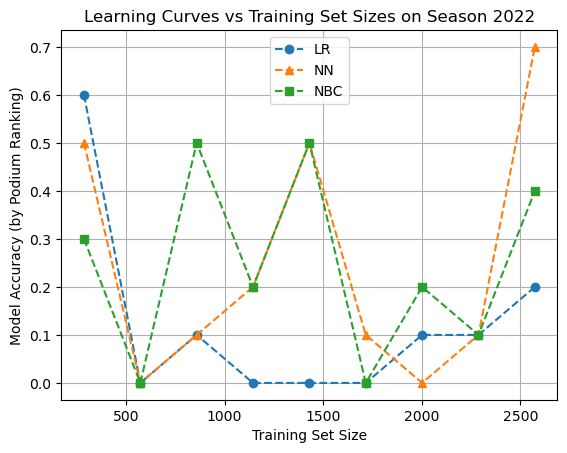

In [94]:
# features = [
#     'season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins', 
#     'constructor_points', 'constructor_standings_pos', 'constructor_wins',
#     'fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3',
#     'weather_cloudy', 'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet'
# ]

features = ['season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins',
            'constructor_points', 'constructor_standings_pos', 'constructor_wins']
additional_features = ['fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3']
features = features + additional_features

data = pd.read_csv('./data/preprocessed_df.csv')
# data['top_10_finish'] = np.where(data['podium'] <= 10, 1, 0)
data['season_end_top_10'] = data.groupby('season')['driver_points'].transform(lambda x: x >= x.nlargest(10).min())

X = data[features]
# y = data['podium']
# y = data['top_10_finish']
y = data['season_end_top_10']

X_train = X[data['season'] < 2022]
y_train = y[data['season'] < 2022]
X_test = X[data['season'] == 2022]

data_w_points = pd.read_csv('./data/final_df.csv')
y_test = data_w_points[data_w_points['season'] == 2022]
y_test = y_test.groupby('driver_name')['points'].sum().reset_index()
y_test = y_test.sort_values('points', ascending=False)
y_test = y_test.iloc[0:10].reset_index(drop=True)
# y_test computes the actual final standing for each driver at the end of the season


#  ===

X_train_partitions = np.array_split(X_train, 10) # for different train sizes
y_train_partitions = np.array_split(y_train, 10) # for different train sizes

lr_accs = []
nn_accs = []
nbc_accs = []
train_size = []
X_train_var = pd.DataFrame()
y_train_var = pd.DataFrame()
for i in range(len(X_train_partitions)-1, 0, -1):
    X_train_var = pd.concat([X_train_var, pd.DataFrame(X_train_partitions[i])])
    y_train_var = pd.concat([y_train_var, pd.DataFrame(y_train_partitions[i])])
    
    X_train_var = X_train_var.sort_index()
    # print(X_train_var.shape)
    # display(X_train_var)

    (lr_pred, lr_acc, lr_mapped_revs, lr_ideal_revs, lr_champ, lr_champ_pts) = fit_n_pred(LR, 2022, X_train_var, y_train_var, X_test, y_test)
    (nn_pred, nn_acc, nn_mapped_revs, nn_ideal_revs, nn_champ, nn_champ_pts) = fit_n_pred(NN, 2022, X_train_var, y_train_var, X_test, y_test)
    (nbc_pred, nbc_acc, nbc_mapped_revs, nbc_ideal_revs, nbc_champ, nbc_champ_pts) = fit_n_pred(NBC, 2022, X_train_var, y_train_var, X_test, y_test)
    train_size.append(X_train_var.shape[0])
    lr_accs.append(lr_acc)
    nn_accs.append(nn_acc)
    nbc_accs.append(nbc_acc)

plt.figure()
plt.plot(train_size, lr_accs, linestyle='--', marker='o', label='LR')
plt.plot(train_size, nn_accs, linestyle='--', marker='^', label='NN')
plt.plot(train_size, nbc_accs, linestyle='--', marker='s', label='NBC')
plt.xlabel('Training Set Size')
plt.ylabel('Model Accuracy (by Podium Ranking)')
plt.legend()
plt.title('Learning Curves vs Training Set Sizes on Season 2022')
plt.grid(True)
plt.show()


	y_test	        y_pred
1	max verstappen	max verstappen  1
2	charles leclerc	charles leclerc 1
3	sergio perez	sergio perez    1
4	george russell	carlos sainz    0
5	lewis hamilton	george russell  0
6	carlos sainz	lewis hamilton  0
7	lando norris	lando norris    1
8	esteban ocon	esteban ocon    1
9	fernando alonso	fernando alonso 1
10	valtteri bottas	valtteri bottas 1

acc = 7/10

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

data = pd.read_csv('./data/preprocessed_df.csv')
data_w_points = pd.read_csv('./data/final_df.csv')

def lr(X_train, y_train, X_test, y_test, year):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    logreg = LogisticRegression()
    logreg.fit(X_train_scaled, y_train)

    probabilities = logreg.predict_proba(X_test_scaled)[:, 1]

    data_2022 = data[data['season'] == year].copy()
    data_2022['predicted_probability'] = probabilities

    driver_probabilities = data_2022.groupby('driver_name')['predicted_probability'].mean().sort_values(ascending=False)
    top_10_finishers = driver_probabilities.head(10)

    y_pred = logreg.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    return (y_pred, accuracy, top_10_finishers)

def nn(X_train, y_train, X_test, y_tes, year):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    neuralnet = MLPClassifier(solver='sgd', batch_size= 100, random_state=0, max_iter=1000)
    neuralnet.fit(X_train_scaled, y_train)

    probabilities = neuralnet.predict_proba(X_test_scaled)[:, 1]

    data_2022 = data[data['season'] == year].copy()
    data_2022['predicted_probability'] = probabilities

    driver_probabilities = data_2022.groupby('driver_name')['predicted_probability'].mean().sort_values(ascending=False)
    top_10_finishers = driver_probabilities.head(10)

    y_pred = neuralnet.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    return (y_pred, accuracy, top_10_finishers)

def nbc(X_train, y_train, X_test, y_test, year):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    nbc = GaussianNB()
    nbc.fit(X_train_scaled, y_train)

    probabilities = nbc.predict_proba(X_test_scaled)[:, 1]

    data_2022 = data[data['season'] == year].copy()
    data_2022['predicted_probability'] = probabilities

    driver_probabilities = data_2022.groupby('driver_name')['predicted_probability'].mean().sort_values(ascending=False)
    top_10_finishers = driver_probabilities.head(10)

    y_pred = nbc.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    return (y_pred, accuracy, top_10_finishers)

# features = [
#     'season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins', 
#     'constructor_points', 'constructor_standings_pos', 'constructor_wins',
#     'fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3',
#     'weather_cloudy', 'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet'
# ]
features = ['season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins',
            'constructor_points', 'constructor_standings_pos', 'constructor_wins']
additional_features = ['fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3']
features = features + additional_features

data['season_end_top_10'] = data.groupby('season')['driver_points'].transform(lambda x: x >= x.nlargest(10).min())

X = data[features]
y = data['season_end_top_10']

results = {
    'year': [y for y in range(2019, 2024)],
    'LR Acc Top-10': [],
    'NN Acc Top-10': [],
    'NBC Acc Top-10': [],
}

for year in range(2019, 2024):
    X_train = X[data['season'] < year]
    y_train = y[data['season'] < year]
    X_test = X[data['season'] == year]
    y_test = y[data['season'] == year]

    (lr_pred, lr_acc, lr_top10) = lr(X_train_var, y_train_var, X_test, y_test, year)
    (nn_pred, nn_acc, nn_top10) = nn(X_train_var, y_train_var, X_test, y_test, year)
    (nbc_pred, nbc_acc, nbc_top10) = nbc(X_train_var, y_train_var, X_test, y_test, year)

    results['LR Acc Top-10'].append(lr_acc)
    results['NN Acc Top-10'].append(nn_acc)
    results['NBC Acc Top-10'].append(nbc_acc)

results_df = pd.DataFrame(results)
display(results_df)
results_df.drop(columns=['year'], inplace=True)

final_results_df = pd.read_csv('./final_results.csv')
final_results_df = pd.concat([final_results_df, results_df], axis=1)
final_results_df = final_results_df[['year', 'LR Acc Podium', 'LR Acc Top-10', 'LR NDCG', 'NN Acc Podium', 'NN Acc Top-10', 'NN NDCG', 'NBC Acc Podium', 'NBC Acc Top-10', 'NBC NDCG']]

display(final_results_df)
latex_table = dataframe_to_latex(final_results_df, caption=f"Performance Comparison", label=f"tab:perf_comp", position="ht")
print(latex_table)

# X_train_partitions = np.array_split(X_train, 10) # for different train sizes
# y_train_partitions = np.array_split(y_train, 10) # for different train sizes

# lr_accs = []
# train_size = []
# X_train_var = pd.DataFrame()
# y_train_var = pd.DataFrame()
# for i in range(len(X_train_partitions)-1, 0, -1):
#     X_train_var = pd.concat([X_train_var, pd.DataFrame(X_train_partitions[i])])
#     y_train_var = pd.concat([y_train_var, pd.DataFrame(y_train_partitions[i])])
    
#     X_train_var = X_train_var.sort_index()
#     # print(X_train_var.shape)
#     # display(X_train_var)

    # (lr_pred, lr_acc, lr_top10) = lr(X_train_var, y_train_var, X_test, y_test)
    # train_size.append(X_train_var.shape[0])
    # lr_accs.append(lr_acc)

# plt.figure()
# plt.plot(train_size, lr_accs, marker='o', label='LR')
# plt.xlabel('Training Set Size')
# plt.ylabel('Model Accuracy')
# plt.legend()
# plt.title('Learning Curve of LR with Different Training Set Sizes')
# plt.grid(True)
# plt.show()

,year,LR Acc Top-10,NN Acc Top-10,NBC Acc Top-10
0,2019,0.976190,0.976190,0.938095
1,2020,0.970588,0.970588,0.976471
2,2021,0.977273,0.977273,0.940909
3,2022,0.981818,0.977273,0.929545
4,2023,0.993182,0.979545,0.954545


,year,LR Acc Podium,LR Acc Top-10,LR NDCG,NN Acc Podium,NN Acc Top-10,NN NDCG,NBC Acc Podium,NBC Acc Top-10,NBC NDCG
0,2019,0.1,0.976190,0.651573,0.6,0.976190,0.821400,0.4,0.938095,0.835956
1,2020,0.0,0.970588,0.627772,0.3,0.970588,0.824303,0.3,0.976471,0.834290
2,2021,0.2,0.977273,0.695603,0.1,0.977273,0.808804,0.5,0.940909,0.839411
3,2022,0.5,0.981818,0.832180,0.5,0.977273,0.846201,0.7,0.929545,0.844071
4,2023,0.2,0.993182,0.884320,0.2,0.979545,0.896677,0.4,0.954545,0.892651


\begin{table}[ht]
\centering
\begin{tabular}{rrrrrrrrrr}
\toprule
year & LR Acc Podium & LR Acc Top-10 & LR NDCG & NN Acc Podium & NN Acc Top-10 & NN NDCG & NBC Acc Podium & NBC Acc Top-10 & NBC NDCG \\
\midrule
2019 & 0.100000 & 0.976190 & 0.651573 & 0.600000 & 0.976190 & 0.821400 & 0.400000 & 0.938095 & 0.835956 \\
2020 & 0.000000 & 0.970588 & 0.627772 & 0.300000 & 0.970588 & 0.824303 & 0.300000 & 0.976471 & 0.834290 \\
2021 & 0.200000 & 0.977273 & 0.695603 & 0.100000 & 0.977273 & 0.808804 & 0.500000 & 0.940909 & 0.839411 \\
2022 & 0.500000 & 0.981818 & 0.832180 & 0.500000 & 0.977273 & 0.846201 & 0.700000 & 0.929545 & 0.844071 \\
2023 & 0.200000 & 0.993182 & 0.884320 & 0.200000 & 0.979545 & 0.896677 & 0.400000 & 0.954545 & 0.892651 \\
\bottomrule
\end{tabular}

\caption{Performance Comparison}
\label{tab:perf_comp}
\end{table}


# Original LR Untouched

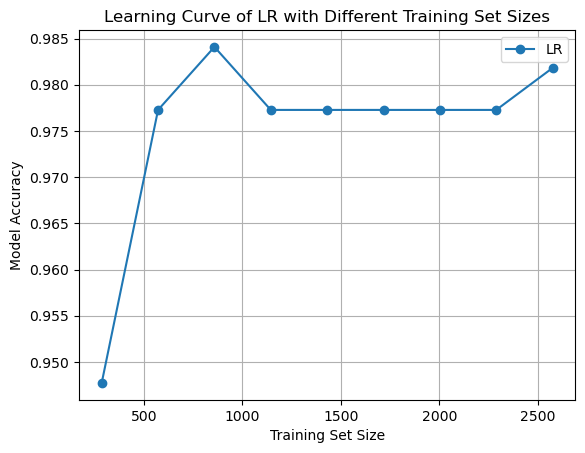

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

data = pd.read_csv('./data/preprocessed_df.csv')
data_w_points = pd.read_csv('./data/final_df.csv')

def lr(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    logreg = LogisticRegression()
    logreg.fit(X_train_scaled, y_train)

    probabilities = logreg.predict_proba(X_test_scaled)[:, 1]

    data_2022 = data[data['season'] == 2022].copy()
    data_2022['predicted_probability'] = probabilities

    driver_probabilities = data_2022.groupby('driver_name')['predicted_probability'].mean().sort_values(ascending=False)
    top_10_finishers = driver_probabilities.head(10)

    y_pred = logreg.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    return (y_pred, accuracy, top_10_finishers)

# features = [
#     'season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins', 
#     'constructor_points', 'constructor_standings_pos', 'constructor_wins',
#     'fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3',
#     'weather_cloudy', 'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet'
# ]
features = ['season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins',
            'constructor_points', 'constructor_standings_pos', 'constructor_wins']
additional_features = ['fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3']
features = features + additional_features

data['season_end_top_10'] = data.groupby('season')['driver_points'].transform(lambda x: x >= x.nlargest(10).min())

X = data[features]
y = data['season_end_top_10']

X_train = X[data['season'] < 2022]
y_train = y[data['season'] < 2022]
X_test = X[data['season'] == 2022]
y_test = y[data['season'] == 2022]

X_train_partitions = np.array_split(X_train, 10) # for different train sizes
y_train_partitions = np.array_split(y_train, 10) # for different train sizes

lr_accs = []
train_size = []
X_train_var = pd.DataFrame()
y_train_var = pd.DataFrame()
for i in range(len(X_train_partitions)-1, 0, -1):
    X_train_var = pd.concat([X_train_var, pd.DataFrame(X_train_partitions[i])])
    y_train_var = pd.concat([y_train_var, pd.DataFrame(y_train_partitions[i])])
    
    X_train_var = X_train_var.sort_index()
    # print(X_train_var.shape)
    # display(X_train_var)

    (lr_pred, lr_acc, lr_top10) = lr(X_train_var, y_train_var, X_test, y_test)
    train_size.append(X_train_var.shape[0])
    lr_accs.append(lr_acc)

plt.figure()
plt.plot(train_size, lr_accs, marker='o', label='LR')
plt.xlabel('Training Set Size')
plt.ylabel('Model Accuracy')
plt.legend()
plt.title('Learning Curve of LR with Different Training Set Sizes')
plt.grid(True)
plt.show()

driver     y_test  y_pred
driver1,   true,   true    1
driver2,   false,  true    0
driver3,   true,   false   0
driver4,   false,  false   1
driver5,   true,   false   0
driver6,   false,  fasle   1
driver7,   false,  fasle   1
driver8,   false,  fasle   1
driver9,   true,   true    1
driver10,  true,   false   0

acc = 6/10

For every driver, is it in the top 10 (true or false)

For all rounds in season 2022, each driver has either true or false

# Original NN Untouched
**Notice that this implementation uses the second method!**
```
data['top_10_finish'] = np.where(data['podium'] <= 10, 1, 0)
X = data[all_features]
y = data['top_10_finish']
```

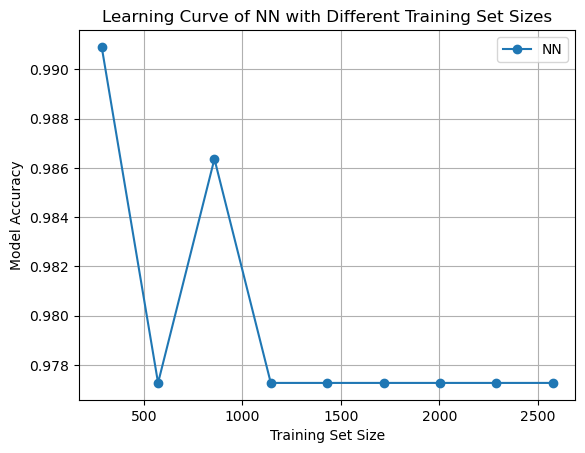

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

data = pd.read_csv('./data/preprocessed_df.csv')

def nn(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    neuralnet = MLPClassifier(solver='sgd', batch_size= 100, random_state=0, max_iter=1000)
    neuralnet.fit(X_train_scaled, y_train)

    probabilities = neuralnet.predict_proba(X_test_scaled)[:, 1]

    data_2022 = data[data['season'] == 2022].copy()
    data_2022['predicted_probability'] = probabilities

    driver_probabilities = data_2022.groupby('driver_name')['predicted_probability'].mean().sort_values(ascending=False)
    top_10_finishers = driver_probabilities.head(10)

    y_pred = neuralnet.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    return (y_pred, accuracy, top_10_finishers)

# features = [
#     'season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins', 
#     'constructor_points', 'constructor_standings_pos', 'constructor_wins',
#     'fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3',
#     'weather_cloudy', 'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet'
# ]
features = ['season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins',
            'constructor_points', 'constructor_standings_pos', 'constructor_wins']
additional_features = ['fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3']
features = features + additional_features

data['season_end_top_10'] = data.groupby('season')['driver_points'].transform(lambda x: x >= x.nlargest(10).min())

X = data[features]
y = data['season_end_top_10']

# X = data[all_features]
# y = data['top_10_finish']

X_train = X[data['season'] < 2022]
y_train = y[data['season'] < 2022]
X_test = X[data['season'] == 2022]
y_test = y[data['season'] == 2022]

X_train_partitions = np.array_split(X_train, 10) # for different train sizes
y_train_partitions = np.array_split(y_train, 10) # for different train sizes

nn_accs = []
train_size = []
X_train_var = pd.DataFrame()
y_train_var = pd.DataFrame()
for i in range(len(X_train_partitions)-1, 0, -1):
    X_train_var = pd.concat([X_train_var, pd.DataFrame(X_train_partitions[i])])
    y_train_var = pd.concat([y_train_var, pd.DataFrame(y_train_partitions[i])])
    
    X_train_var = X_train_var.sort_index()
    # print(X_train_var.shape)
    # display(X_train_var)

    (nn_pred, nn_acc, nn_top10) = nn(X_train_var, y_train_var, X_test, y_test)
    train_size.append(X_train_var.shape[0])
    nn_accs.append(nn_acc)

plt.figure()
plt.plot(train_size, nn_accs, marker='o', label='NN')
plt.xlabel('Training Set Size')
plt.ylabel('Model Accuracy')
plt.legend()
plt.title('Learning Curve of NN with Different Training Set Sizes')
plt.grid(True)
plt.show()


# Original NBC Untouched

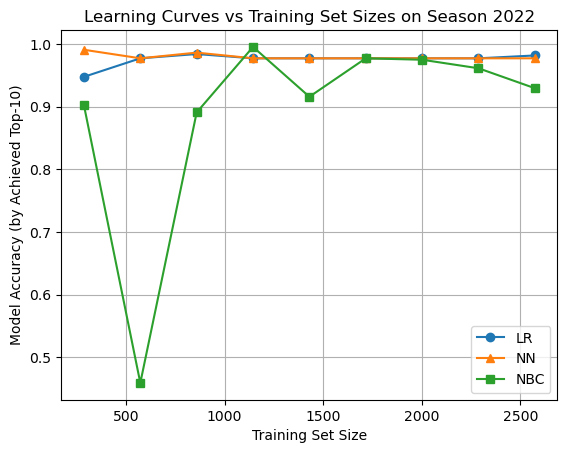

In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

data = pd.read_csv('./data/preprocessed_df.csv')
data_w_points = pd.read_csv('./data/final_df.csv')

def nbc(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    nbc = GaussianNB()
    nbc.fit(X_train_scaled, y_train)

    probabilities = nbc.predict_proba(X_test_scaled)[:, 1]

    data_2022 = data[data['season'] == 2022].copy()
    data_2022['predicted_probability'] = probabilities

    driver_probabilities = data_2022.groupby('driver_name')['predicted_probability'].mean().sort_values(ascending=False)
    top_10_finishers = driver_probabilities.head(10)

    y_pred = nbc.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    return (y_pred, accuracy, top_10_finishers)

# features = [
#     'season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins', 
#     'constructor_points', 'constructor_standings_pos', 'constructor_wins',
#     'fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3',
#     'weather_cloudy', 'weather_cold', 'weather_dry', 'weather_warm', 'weather_wet'
# ]

features = ['season', 'round', 'driver_points', 'driver_standings_pos', 'driver_wins',
            'constructor_points', 'constructor_standings_pos', 'constructor_wins']
additional_features = ['fp_pos_1', 'fp_time_1', 'fp_pos_2', 'fp_time_2', 'fp_pos_3', 'fp_time_3']
features = features + additional_features

data['season_end_top_10'] = data.groupby('season')['driver_points'].transform(lambda x: x >= x.nlargest(10).min())

X = data[features]
y = data['season_end_top_10']

X_train = X[data['season'] < 2022]
y_train = y[data['season'] < 2022]
X_test = X[data['season'] == 2022]
y_test = y[data['season'] == 2022]

X_train_partitions = np.array_split(X_train, 10) # for different train sizes
y_train_partitions = np.array_split(y_train, 10) # for different train sizes

nbc_accs = []
train_size = []
X_train_var = pd.DataFrame()
y_train_var = pd.DataFrame()
for i in range(len(X_train_partitions)-1, 0, -1):
    X_train_var = pd.concat([X_train_var, pd.DataFrame(X_train_partitions[i])])
    y_train_var = pd.concat([y_train_var, pd.DataFrame(y_train_partitions[i])])
    
    X_train_var = X_train_var.sort_index()
    # print(X_train_var.shape)
    # display(X_train_var)

    (nbc_pred, nbc_acc, nbc_top10) = nbc(X_train_var, y_train_var, X_test, y_test)
    train_size.append(X_train_var.shape[0])
    nbc_accs.append(nbc_acc)

plt.figure()
plt.plot(train_size, lr_accs, marker='o', label='LR')
plt.plot(train_size, nn_accs, marker='^', label='NN')
plt.plot(train_size, nbc_accs, marker='s', label='NBC')
plt.xlabel('Training Set Size')
plt.ylabel('Model Accuracy (by Achieved Top-10)')
plt.legend()
plt.title('Learning Curves vs Training Set Sizes on Season 2022')
plt.grid(True)
plt.show()

Merging the "Originals"

### Old Code

```python
def lr(X_train, y_train, X_test, y_test, output=False):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    logreg = LogisticRegression(penalty='l1', solver='saga', C=10.0, max_iter=1500)
    logreg.fit(X_train_scaled, y_train)

    # probabilities = neuralnet.predict_proba(X_test_scaled)[:, 1]
    # data_2022['pred_probability'] = probabilities
    # driver_probabilities = data_2022.groupby('driver_name')['pred_probability'].mean().sort_values(ascending=False)
    # top_10_finishers = driver_probabilities.head(10)
    # y_pred = neuralnet.predict(X_test_scaled)
    
    data_2022 = data[data['season'] == 2022].copy()
    data_2022.loc[:, 'pred_probability'] = logreg.predict_proba(X_test_scaled)[:, 1]
    
    top_10_predictions = data_2022.groupby('round').apply(lambda x: x.nlargest(10, 'pred_probability')).reset_index(drop=True)

    unique_rounds = data_2022['round'].unique()

    mapped_revs = []
    ideal_revs = []

    for r in unique_rounds:
        round_predictions = top_10_predictions[top_10_predictions['round'] == r]
        round_predictions = round_predictions[['season', 'round', 'driver_name', 'pred_probability', 'podium']]
        round_predictions = round_predictions.reset_index(drop=True)
        round_predictions['pred_podium'] = round_predictions.index + 1
        
        # print(f"Round {r} predictions:")
        # display(round_predictions[['driver_name', 'podium', 'pred_podium']])
        
        podium_vals = round_predictions['podium'].tolist()
        podium_vals = [int(val) for val in podium_vals]
        true_relevances = assign_relevance(podium_vals)
        predicted_relevances = assign_relevance(round_predictions['pred_podium'].tolist())
        
        # Map true relevances to the order of predicted relevances
        mapped_true_relevances = map_true_relevances_to_predicted_order(true_relevances, predicted_relevances)
        # Calculate NDCG for the mapped true relevances
        ndcg_score_mapped = calculate_ndcg(mapped_true_relevances, len(mapped_true_relevances))
        # Calculate ideal NDCG for true relevances
        ideal_ndcg_score = calculate_ndcg(sorted(true_relevances, reverse=True), len(true_relevances))
        mapped_revs.append(ndcg_score_mapped)
        ideal_revs.append(ideal_ndcg_score)

    top_10_predictions = assign_points(top_10_predictions)
    # Summing up points for each driver
    season_points = top_10_predictions.groupby('driver_name')['predicted_points'].sum().reset_index()
    # Sorting drivers based on total points
    season_points = season_points.sort_values('predicted_points', ascending=False)

    y_test = y_test['driver_name'].tolist()
    y_pred = season_points['driver_name'].head(10).tolist()

    accuracy = accuracy_score(y_test, y_pred)
    comp_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    if output: print("Logistic Regression")
    if output: display(comp_df)

    pred_champ = season_points.iloc[0]['driver_name']
    pred_champ_points = season_points.iloc[0]['predicted_points']

    return (y_pred, accuracy, mapped_revs, ideal_revs, pred_champ, pred_champ_points)

def nn(X_train, y_train, X_test, y_test, output=False):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    neuralnet = MLPClassifier(hidden_layer_sizes=(80,20,40,5), activation='relu', solver='adam', alpha=1.2742749857031321, batch_size= 100, random_state=0, max_iter=2000)
    neuralnet.fit(X_train_scaled, y_train)

    # probabilities = neuralnet.predict_proba(X_test_scaled)[:, 1]
    # data_2022['pred_probability'] = probabilities
    # driver_probabilities = data_2022.groupby('driver_name')['pred_probability'].mean().sort_values(ascending=False)
    # top_10_finishers = driver_probabilities.head(10)
    # y_pred = neuralnet.predict(X_test_scaled)
    
    data_2022 = data[data['season'] == 2022].copy()
    data_2022.loc[:, 'pred_probability'] = neuralnet.predict_proba(X_test_scaled)[:, 1]
    
    top_10_predictions = data_2022.groupby('round').apply(lambda x: x.nlargest(10, 'pred_probability')).reset_index(drop=True)

    unique_rounds = data_2022['round'].unique()

    mapped_revs = []
    ideal_revs = []

    for r in unique_rounds:
        round_predictions = top_10_predictions[top_10_predictions['round'] == r]
        round_predictions = round_predictions[['season', 'round', 'driver_name', 'pred_probability', 'podium']]
        round_predictions = round_predictions.reset_index(drop=True)
        round_predictions['pred_podium'] = round_predictions.index + 1
        
        # print(f"Round {r} predictions:")
        # display(round_predictions[['driver_name', 'podium', 'pred_podium']])

        podium_vals = round_predictions['podium'].tolist()
        podium_vals = [int(val) for val in podium_vals]
        true_relevances = assign_relevance(podium_vals)
        predicted_relevances = assign_relevance(round_predictions['pred_podium'].tolist())

        # Map true relevances to the order of predicted relevances
        mapped_true_relevances = map_true_relevances_to_predicted_order(true_relevances, predicted_relevances)
        # Calculate NDCG for the mapped true relevances
        ndcg_score_mapped = calculate_ndcg(mapped_true_relevances, len(mapped_true_relevances))
        # Calculate ideal NDCG for true relevances
        ideal_ndcg_score = calculate_ndcg(sorted(true_relevances, reverse=True), len(true_relevances))
        mapped_revs.append(ndcg_score_mapped)
        ideal_revs.append(ideal_ndcg_score)

    top_10_predictions = assign_points(top_10_predictions)
    # Summing up points for each driver
    season_points = top_10_predictions.groupby('driver_name')['predicted_points'].sum().reset_index()
    # Sorting drivers based on total points
    season_points = season_points.sort_values('predicted_points', ascending=False)

    y_test = y_test['driver_name'].tolist()
    y_pred = season_points['driver_name'].head(10).tolist()

    accuracy = accuracy_score(y_test, y_pred)
    comp_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    if output: print("Neural Network")
    if output: display(comp_df)

    pred_champ = season_points.iloc[0]['driver_name']
    pred_champ_points = season_points.iloc[0]['predicted_points']

    return (y_pred, accuracy, mapped_revs, ideal_revs, pred_champ, pred_champ_points)

def nbc(X_train, y_train, X_test, y_test, output=False):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    nbc = GaussianNB(var_smoothing=2.848035868435799e-05)
    nbc.fit(X_train_scaled, y_train)

    # probabilities = neuralnet.predict_proba(X_test_scaled)[:, 1]
    # data_2022['pred_probability'] = probabilities
    # driver_probabilities = data_2022.groupby('driver_name')['pred_probability'].mean().sort_values(ascending=False)
    # top_10_finishers = driver_probabilities.head(10)
    # y_pred = neuralnet.predict(X_test_scaled)
    
    data_2022 = data[data['season'] == 2022].copy()
    data_2022.loc[:, 'pred_probability'] = nbc.predict_proba(X_test_scaled)[:, 1]
    
    top_10_predictions = data_2022.groupby('round').apply(lambda x: x.nlargest(10, 'pred_probability')).reset_index(drop=True)

    unique_rounds = data_2022['round'].unique()

    mapped_revs = []
    ideal_revs = []

    for r in unique_rounds:
        round_predictions = top_10_predictions[top_10_predictions['round'] == r]
        round_predictions = round_predictions[['season', 'round', 'driver_name', 'pred_probability', 'podium']]
        round_predictions = round_predictions.reset_index(drop=True)
        round_predictions['pred_podium'] = round_predictions.index + 1
        
        # print(f"Round {r} predictions:")
        # display(round_predictions[['driver_name', 'podium', 'pred_podium']])

        podium_vals = round_predictions['podium'].tolist()
        podium_vals = [int(val) for val in podium_vals]
        true_relevances = assign_relevance(podium_vals)
        predicted_relevances = assign_relevance(round_predictions['pred_podium'].tolist())

        # Map true relevances to the order of predicted relevances
        mapped_true_relevances = map_true_relevances_to_predicted_order(true_relevances, predicted_relevances)
        # Calculate NDCG for the mapped true relevances
        ndcg_score_mapped = calculate_ndcg(mapped_true_relevances, len(mapped_true_relevances))
        # Calculate ideal NDCG for true relevances
        ideal_ndcg_score = calculate_ndcg(sorted(true_relevances, reverse=True), len(true_relevances))
        mapped_revs.append(ndcg_score_mapped)
        ideal_revs.append(ideal_ndcg_score)

    top_10_predictions = assign_points(top_10_predictions)
    # Summing up points for each driver
    season_points = top_10_predictions.groupby('driver_name')['predicted_points'].sum().reset_index()
    # Sorting drivers based on total points
    season_points = season_points.sort_values('predicted_points', ascending=False)

    y_test = y_test['driver_name'].tolist()
    y_pred = season_points['driver_name'].head(10).tolist()

    accuracy = accuracy_score(y_test, y_pred)
    comp_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    if output: print("Naive Bayes Classifier")
    if output: display(comp_df)

    pred_champ = season_points.iloc[0]['driver_name']
    pred_champ_points = season_points.iloc[0]['predicted_points']

    return (y_pred, accuracy, mapped_revs, ideal_revs, pred_champ, pred_champ_points)
```